# Installing Hub

In [ ]:
!pip3 install hub --quiet

# Run below cells and restart the runtime
# if you are running it in colab
# import os
# os.kill(os.getpid(), 9) 

# Download raw dataset

In [1]:
from IPython.display import clear_output

In [12]:
from PIL import Image 
import numpy as np 
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# Download Dataset here
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
!unzip warwick_qu_dataset_released_2016_07_08.zip
clear_output()

# Creating dataset on hub

**Activeloop API** : https://docs.activeloop.ai/api-basics

In [ ]:
import hub

# Login to ActiveLoop

%env BUGGER_OFF=True
!activeloop login -u username -p password
!activeloop reporting --off

In [5]:
base_path = 'Warwick QU Dataset (Released 2016_07_08)'

In [6]:
columns = ['name', 'patient_ID', 'grade_Glas', 'grade_Sirinukunwattana']
df = pd.read_csv(os.path.join(base_path, 'Grade.csv'), skipinitialspace=True)
df.columns = columns

In [7]:
df.columns

Index(['name', 'patient_ID', 'grade_Glas', 'grade_Sirinukunwattana'], dtype='object')

In [8]:
grade_Glas = list(df.grade_Glas.unique())
grade_Sirinukunwattana = list(df.grade_Sirinukunwattana.unique())

In [9]:
grade_Glas

['benign', 'malignant']

In [ ]:
dataset_type = 'train' # [train, test]
hubname = f'hub://<username>/glas-{dataset_type}'
ds = hub.dataset(hubname)

with ds:

    ds.create_tensor('images', htype='image', sample_compression='bmp')
    ds.create_tensor('masks', htype='binary_mask', sample_compression='lz4')
    ds.create_tensor('grade_glas', htype='class_label', class_names=grade_Glas)
    ds.create_tensor('grade_sirinukunwattana', htype='class_label', class_names=grade_Sirinukunwattana)
    ds.create_tensor('patient_ids')
    
    data_rows = df[df['name'].str.startswith(dataset_type)]

    for index, row in tqdm(data_rows.iterrows()):
        image_path = os.path.join(base_path, row['name']+'.bmp')
        mask_path = os.path.join(base_path, row['name']+'_anno.bmp')

        img_pil = Image.open(mask_path).convert('L')
        mask = np.array(img_pil, dtype='uint16')
        m, n = mask.shape
        mask = mask.reshape(m, n, 1)

        ds.append({
            'images' : hub.read(image_path),
            'masks' : mask.astype('bool'),
            'grade_glas' : grade_Glas.index(row['grade_Glas']),
            'grade_sirinukunwattana' : grade_Sirinukunwattana.index(row['grade_Sirinukunwattana']),
            'patient_ids' : np.int8(row['patient_ID'])
        })

# Testing dataset from hub

In [ ]:
hub_path = "hub://<username>/glas-train"
ds = hub.dataset(hub_path)

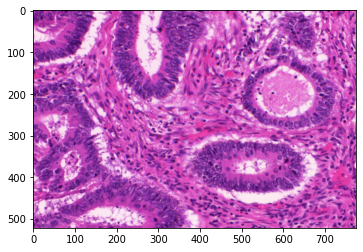

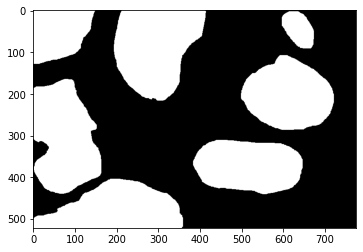

In [25]:
index=0
plt.imshow(ds.images[index].numpy())
plt.show()
plt.imshow(ds.masks[index].numpy(), cmap='gray')
plt.show()

In [ ]:
hub_path = "hub://<username>/glas-test"
ds = hub.dataset(hub_path)

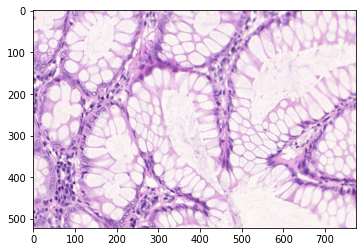

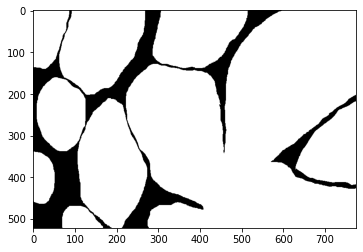

In [27]:
index=0
plt.imshow(ds.images[index].numpy())
plt.show()
plt.imshow(ds.masks[index].numpy(), cmap='gray')
plt.show()